In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as lf
from lifelines.utils.sklearn_adapter import sklearn_adapter


import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

In [2]:
# let's get our data
data = pd.read_csv('clean2class/afib_425_4_clean_X2.csv')
T, E = data['duration'], data['event']
data.describe()

,duration,event,age,afib_0.0,afib_1.0,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
count,792179.000000,792179.000000,792179.000000,792179.00000,792179.00000,792179.000000,792179.000000,792179.000000,792179.000000,792179.000000,792179.000000,792179.000000,792179.000000,792179.000000
mean,1093.394793,0.163431,76.073752,0.14336,0.85664,0.475133,0.524867,0.373326,0.032079,0.064677,0.038289,0.000302,0.005761,0.485566
std,896.348655,0.369759,13.122916,0.35044,0.35044,0.499382,0.499382,0.483688,0.176209,0.245956,0.191894,0.017367,0.075684,0.499792
min,1.000000,0.000000,-66.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.000000,0.000000,69.000000,0.00000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,923.000000,0.000000,79.000000,0.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1780.000000,0.000000,86.000000,0.00000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,7889.000000,1.000000,110.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
data.head()

,duration,event,age,afib_0.0,afib_1.0,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
0,203.0,1.0,89.0,0,1,0,1,0,0,0,0,0,1,0
1,2048.0,1.0,70.0,0,1,1,0,1,0,0,0,0,0,0
2,1972.0,1.0,97.0,0,1,0,1,0,0,0,1,0,0,0
3,1809.0,1.0,67.0,0,1,0,1,1,0,0,0,0,0,0
4,1647.0,1.0,87.0,0,1,1,0,0,0,0,1,0,0,0


In [4]:
data.shape[0] # number of patients

792179

In [5]:
censorship_counts = data['event'].value_counts()
censor_rate = censorship_counts[0] / censorship_counts[1]
print('Censor Rate:', str(round(censor_rate, 2)*100) + '%')

Censor Rate: 512.0%


In [6]:
# number of positive (1) and negative (0) patients
data['afib_1.0'].value_counts()

1    678612
0    113567
Name: afib_1.0, dtype: int64

In [7]:
X = pd.DataFrame(data.drop('duration', axis=1))
Y = pd.DataFrame(data['duration'])

X['age'] = preprocessing.scale(X['age'])
X

,event,age,afib_0.0,afib_1.0,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
0,1.0,0.985014,0,1,0,1,0,0,0,0,0,1,0
1,1.0,-0.462836,0,1,1,0,1,0,0,0,0,0,0
2,1.0,1.594635,0,1,0,1,0,0,0,1,0,0,0
3,1.0,-0.691444,0,1,0,1,1,0,0,0,0,0,0
4,1.0,0.832609,0,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
792174,1.0,-4.044359,1,0,0,1,1,0,0,0,0,0,0
792175,1.0,0.146785,1,0,1,0,1,0,0,0,0,0,0
792176,1.0,0.451596,1,0,1,0,0,0,0,0,0,0,1
792177,1.0,0.985014,1,0,0,1,1,0,0,0,0,0,0


In [8]:
trainX, valX, trainY, valY = model_selection.train_test_split(X, Y)
trainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)

trainX.columns=['event','age','neg','pos','male','fem','r1','r2','r3','r4','r5','r6','r9'] 
valX.columns=['event','age','neg','pos','male','fem','r1','r2','r3','r4','r5','r6','r9'] 

### Linear Regression

In [9]:
lrg = LinearRegression()
lrg.fit(trainX, trainY)
print(lf.utils.concordance_index(valY, lrg.predict(valX), event_observed=valX['event']))

0.779450151177418


### Cox Regression

In [10]:
CoxRegression = sklearn_adapter(lf.CoxPHFitter, event_col='event')
sk_cph = CoxRegression(penalizer=.1)

sk_cph.fit(trainX, trainY)
sk_cph.lifelines_model.print_summary()

In [11]:
sk_cph.score(valX, valY)

0.9190500668921459

In [12]:
'''
cph = lf.CoxPHFitter(penalizer=.1)
cph.fit(data, 'duration','event')
cph.check_assumptions(data)
'''

"\ncph = lf.CoxPHFitter(penalizer=.1)\ncph.fit(data, 'duration','event')\ncph.check_assumptions(data)\n"

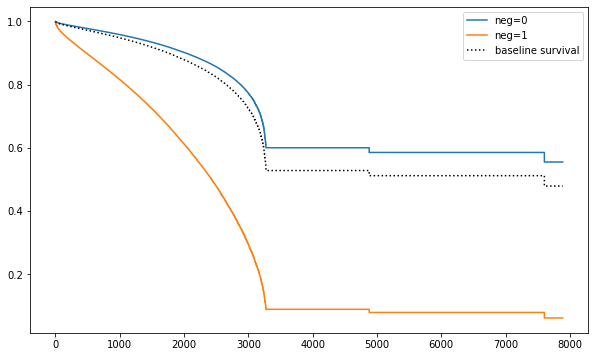

In [13]:
sk_cph.lifelines_model.plot_covariate_groups('neg', values=[0,1], figsize=(10,6))

### Weibull AFT

In [14]:
'''
# get best parameters for WeibullAFT
WeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col='event')
sk_wf = WeibullAFT()

clf = model_selection.GridSearchCV(sk_wf, {
    "penalizer":10.0 ** np.arange(-2, 3),
    "l1_ratio": [0, 1/3, 2/3],
    "model_ancillary":[True,False],
}, cv=4)
clf.fit(trainX, trainY)
print(clf.best_estimator_)
'''

'\n# get best parameters for WeibullAFT\nWeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col=\'event\')\nsk_wf = WeibullAFT()\n\nclf = model_selection.GridSearchCV(sk_wf, {\n    "penalizer":10.0 ** np.arange(-2, 3),\n    "l1_ratio": [0, 1/3, 2/3],\n    "model_ancillary":[True,False],\n}, cv=4)\nclf.fit(trainX, trainY)\nprint(clf.best_estimator_)\n'

In [17]:
WeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col='event')

sk_wf = WeibullAFT(penalizer=.1)
sk_wf.fit(trainX, trainY)
sk_wf.lifelines_model.print_summary()

In [18]:
sk_wf.score(valX, valY)

0.919030602247259

In [19]:
sk_wf.lifelines_model.mean_survival_time_

10371.80276955448

In [20]:
sk_wf.lifelines_model.median_survival_time_

8117.234398694523

In [ ]:
sk_wf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

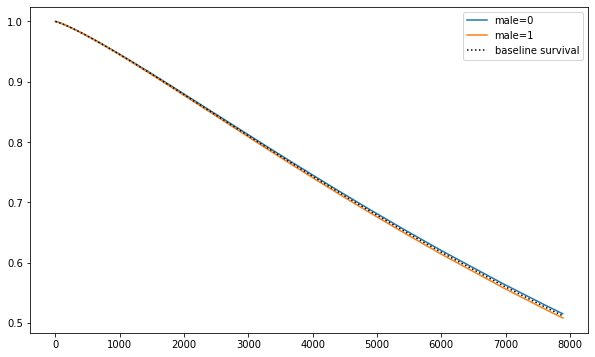

In [22]:
sk_wf.lifelines_model.plot_covariate_groups('male', values=[0,1], figsize=(10,6))

### Log-Normal AFT

In [23]:
LogNormAFT = sklearn_adapter(lf.LogNormalAFTFitter, event_col='event')

sk_lnf = LogNormAFT()
sk_lnf.fit(trainX, trainY)
sk_lnf.lifelines_model.print_summary()

C:\Users\tug84786\AppData\Local\Continuum\miniconda3\lib\site-packages\lifelines\fitters\__init__.py:1953: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogNormalAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)


In [24]:
sk_lnf.score(valX, valY)

0.9188404213403358

In [25]:
sk_lnf.lifelines_model.mean_survival_time_

49913.747476661316

In [26]:
sk_lnf.lifelines_model.median_survival_time_

14893.915911342192

In [ ]:
sk_lnf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

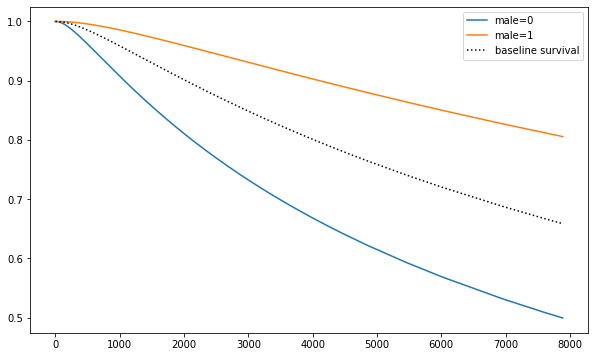

In [28]:
sk_lnf.lifelines_model.plot_covariate_groups('male', values=[0,1], figsize=(10,6))

### Log-Logistic AFT

In [29]:
LogLogAFT = sklearn_adapter(lf.LogLogisticAFTFitter, event_col='event')

sk_llf = LogLogAFT()
sk_llf.fit(trainX, trainY)
sk_llf.lifelines_model.print_summary()

C:\Users\tug84786\AppData\Local\Continuum\miniconda3\lib\site-packages\lifelines\fitters\__init__.py:1953: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogLogisticAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)


In [30]:
sk_llf.score(valX, valY)

0.9188529982590964

In [31]:
sk_llf.lifelines_model.mean_survival_time_

51953.45403476461

In [32]:
sk_llf.lifelines_model.median_survival_time_

12829.759019610598

In [ ]:
sk_llf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

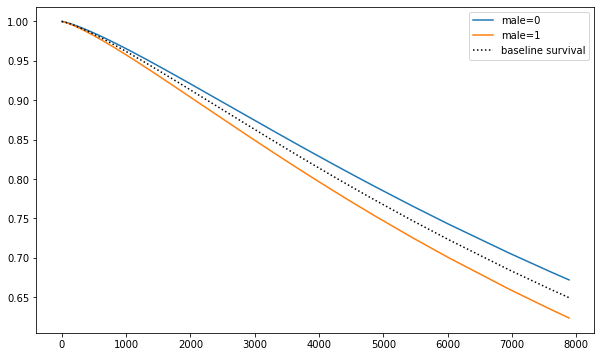

In [34]:
sk_llf.lifelines_model.plot_covariate_groups('male', values=[0,1], figsize=(10,6))

### Compare AFTs

In [ ]:
print('Weibull:', sk_wf.lifelines_model.log_likelihood_)
print('Log-Norm:', sk_lnf.lifelines_model.log_likelihood_)
print('Log-Log:', sk_llf.lifelines_model.log_likelihood_)

### Aalen's Additive Regression

In [36]:
aff = lf.AalenAdditiveFitter(coef_penalizer=.05)
aff.fit(data, duration_col='duration', event_col='event')
aff.print_summary()

### K-Fold Cross-Validation

##### Aalen's

In [ ]:
print(np.mean(lf.utils.k_fold_cross_validation(lf.AalenAdditiveFitter(coef_penalizer=.1), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

##### Weibull AFT

In [ ]:
print(np.mean(lf.utils.k_fold_cross_validation(lf.WeibullAFTFitter(), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

##### Cox

In [ ]:
print(np.mean(lf.utils.k_fold_cross_validation(lf.CoxPHFitter(penalizer=.05), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

### scikit-survival models

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

In [ ]:
data['event'] = data['event'].astype(bool)
X = pd.DataFrame(data.drop(['duration','event'], axis=1))
Y = pd.DataFrame(data[['event','duration']])

X['age'] = preprocessing.scale(X['age'])

trainX, valX, trainY, valY = model_selection.train_test_split(X, Y)
trainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)

trainY = trainY.to_records(index=False)

valY = valY.to_records(index=False)

trainX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9']
valX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9'] 

##### Cox variation with elastic net penalty

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

cphnet = CoxnetSurvivalAnalysis()
cphnet.fit(trainX, trainY)

In [ ]:
cphnet.score(valX, valY)

##### sksurv's Cox implementation

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

cph = CoxPHSurvivalAnalysis()
pd.Series(cph.fit(trainX, trainY))

In [ ]:
cphnet.score(valX, valY)